# QC Mentorship program Screening Task #2

The bit-flip code and the sign-flip code (you can find a description of both [here](https://en.wikipedia.org/wiki/Quantum_error_correction)) are two very simple circuits able to detect and fix the bit-flip and the sign-flip errors, respectively.

>_Note: I am going to use [Qiskit](https://qiskit.org/) as the Quantum Development Framework_

## First Exercise
Build the following simple circuit to prepare the Bell state:
<p>
<img src="task2-circuit.png">
</p>

**Code:**

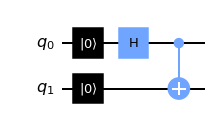

In [57]:
from qiskit import QuantumCircuit, QuantumRegister
# Create 2 qbits circuit
circuitExerciseOne = QuantumCircuit(2)
# By default circuit start with |0>, but we can also explicitely reset it with |0> state
circuitExerciseOne.reset(0)
circuitExerciseOne.reset(1)
# Add a H gate on qubit 0
circuitExerciseOne.h(0)
# Add a CX (CNOT) gate on control qubit 0 and target qubit 1
circuitExerciseOne.cx(0, 1)
# Draw the circuit
circuitExerciseOne.draw('mpl')

## Second Exercise

Now add, right before the CNOT gate and for each of the two qubits, an arbitrary “error gate”. By error gate we mean that with a certain probability (that you can decide but must be non-zero for all the choices) you have a 1 qubit unitary which can be either the identity, or the X gate (bit-flip error) or the Z gate (sign-flip error).

In [16]:
from qiskit import execute, Aer
from qiskit.extensions import UnitaryGate
# Use Aer's qasm_simulator
simulator = Aer.get_backend('qasm_simulator')

In [17]:
def initTwoRandomBits() -> str: 
    """ Creates a random two-bit sequence by the resulting of a one-time execution of a 
        two qubit Quantum Circuit with a Hadamard Gate on each one and performing a Z-measurement.
    """
    # Create 2 qbits circuit with 2 classical registers
    internalCircuit = QuantumCircuit(2,2)
    # Adding Hadamard gates on each qubit
    internalCircuit.h(0)
    internalCircuit.h(1)
    # Map the quantum measurement to the classical bits
    internalCircuit.measure([0,1], [0,1])
    # Execute the circuit on the qasm simulator or just ONE execution
    resultOneExecution = execute(internalCircuit, simulator, shots=1).result()
    # Grab the result in dictionary format
    counts = resultOneExecution.get_counts(internalCircuit)
    # Return the two bit string
    return list(counts.keys())[0]

In [27]:
def randomErrorGate() -> UnitaryGate:
    """ 
        Creates an Unitary Gate, either the identity, X or Z gate with a random probability.
        The probability is computed measuring from a new internal two-qubit circuit qubits, 
        to which it has applied a Hadamard gate to in a superposition state and then to 
        generate an actual random probability. 
        Each qubit is then measured with a Z-measurement and the applied final gate to 
        the input circuit is based on the following output decision table:

        q0 q1 final gate
        -- -- ----------
         0  0  Identity
         0  1  X (bit-flip error)
         1  0  Z (sign-flip error)
         1  1  Identity

         The probability decision table gives a 50% of being the Identity, and a 25% the
         X or the Z gate
    """
    from qiskit.circuit.library import IGate, XGate, ZGate

    twoRandomBits = initTwoRandomBits()
    if (twoRandomBits == "00" or twoRandomBits == "11"):
        return UnitaryGate(IGate(), label="Error Gate (I)")
    if (twoRandomBits == "01"):
        return UnitaryGate(XGate(), label="Error Gate (X)")
    if (twoRandomBits == "10"):
        return UnitaryGate(ZGate(), label="Error Gate (Z)")
    

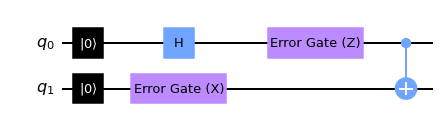

In [55]:
# Create 2 qbits circuit
qreg_q = QuantumRegister(2, 'q')
circuitExerciseTwo = QuantumCircuit(qreg_q)
# By default circuit start with |0>, but we can also explicitely reset it with |0> state
circuitExerciseTwo.reset(0)
circuitExerciseTwo.reset(1)
# Add a H gate on qubit 0
circuitExerciseTwo.h(0)
# Add an error gate on each qubit
circuitExerciseTwo.append(randomErrorGate(), [qreg_q[0]])
circuitExerciseTwo.append(randomErrorGate(), [qreg_q[1]])
# Add a CX (CNOT) gate on control qubit 0 and target qubit 1
circuitExerciseTwo.cx(0, 1)
# Draw the circuit
circuitExerciseTwo.draw('mpl')

## Third Exercise

Encode each of the two qubits with a sign-flip or a bit-flip code, in such a way that **all the possible** choices for the error gates described in 2), occurring on the logical qubits, can be detected and fixed. Motivate your choice. This is the most non-trivial part of the problem, so do it with a lot of care!

### Proposed solution

To solve this part, I am going to use `The Shor code` to fix a possible phase & bit-flip error for a single qubit. To do so, I am codifying the `Shor code` circuit into a unitary operator, so then, I can plug it directly to the final circuit and make it easier to read.
Keep in mind that for a single

In [33]:
aux_qreg_q = QuantumRegister(2, 'aux_q')
code_qreg_q = QuantumRegister(8, 'code_q')
phi_qreg_q = QuantumRegister(1, 'phi')
shorCircuit = QuantumCircuit(phi_qreg_q)
shorCircuit.add_register(code_qreg_q)
shorCircuit.add_register(aux_qreg_q)
print(shorCircuit)

          
   phi_0: 
          
code_q_0: 
          
code_q_1: 
          
code_q_2: 
          
code_q_3: 
          
code_q_4: 
          
code_q_5: 
          
code_q_6: 
          
code_q_7: 
          
 aux_q_0: 
          
 aux_q_1: 
          
 aux_q_2: 
          
 aux_q_3: 
          
 aux_q_4: 
          
 aux_q_5: 
          
 aux_q_6: 
          
 aux_q_7: 
          


## Fourth Exercise

Test your solution by making many measurements over the final state and testing that the results are in line with the expectations.

In [58]:
circuitExerciseOne.measure_all()
print(circuitExerciseOne)
circuitExerciseTwo.measure_all()
print(circuitExerciseTwo)

             ┌───┐      ░ ┌─┐   
   q_0: ─|0>─┤ H ├──■───░─┤M├───
             └───┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ─|0>──────┤ X ├─░──╫─┤M├
                  └───┘ ░  ║ └╥┘
meas: 2/═══════════════════╩══╩═
                           0  1 
                   ┌───┐       ┌────────────────┐      ░ ┌─┐   
   q_0: ─|0>───────┤ H ├───────┤ Error Gate (Z) ├──■───░─┤M├───
             ┌─────┴───┴──────┐└────────────────┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ─|0>─┤ Error Gate (X) ├──────────────────┤ X ├─░──╫─┤M├
             └────────────────┘                  └───┘ ░  ║ └╥┘
meas: 2/══════════════════════════════════════════════════╩══╩═
                                                          0  1 


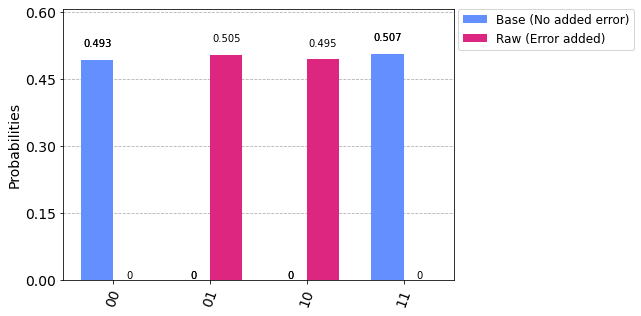

In [59]:
jobExerciseOne = execute(circuitExerciseOne, backend=simulator, shots=5000)
jobExerciseTwo = execute(circuitExerciseTwo, backend=simulator, shots=5000)
resultsExerciseOne = jobExerciseOne.result()
countsExerciseOne = resultsExerciseOne.get_counts()
resultsExerciseTwo = jobExerciseTwo.result()
countsExerciseTwo = resultsExerciseTwo.get_counts()
from qiskit.tools.visualization import *
plot_histogram([countsExerciseOne, countsExerciseTwo], legend=['Base (No added error)', 'Raw (Error added)'])